<pre>
<img align="center" width="300" src="https://portal.coren-sp.gov.br/wp-content/uploads/2014/11/logo%20uninove.png">
</pre>

* __PPGI - UNINOVE__
* Estatística Bayesiana
* Prof. José E. Storópoli
* Aluno: André Santos

### __Introdução:__

Uma empresa de varejo investe parte de seus recursos destinados a publicidade em redes sociais (__LL__). Segundo um especialista em marketing digital dessa empresa investir em redes sociais reduz o custo para atingir cada pessoa na internet e consequentemente aumenta o retorno sobre o investimento (ROI - Return On Investiment). A fim de testar a hipótese levantada pelo especialista, a diretoria de marketing solicitou que fosse analisada a hipótese em questão e em caso afirmativo __quanto o investimento em redes sociais gera de retorno para a empresa?__

### __Metodologia:__

Para analisar o investimento em redes sociais sobre a lucratividade da empresa foi aplicado um modelo Bayesiano Robusto.

Optou-se pelo modelo Bayesiano Robusto, pois há outliers nos dados que não podem ser ignorados, no caso em questão é comum que o ROI seja discrepante, assumindo principalmente valores iguais a zero, o que pode fazer com que estimadores clássicos não apresentem um desempenho satisfatório. A rigor, se as suposições forem atendidas apenas aproximadamente, o estimador robusto ainda terá uma eficiência razoável e um viés razoavelmente pequeno, além de ser assintoticamente não viesado, o que significa que o viés tende a diminuir conforme o tamanho da amostra aumenta (Wikipedia, 2022).

Considerando que essa amostra inicial ao longo dos meses irá aumentar de forma que seja possível periodicamente analisar a eficiência do investimento publicitário em redes sociais, então espera-se que no decorrer dos meses/anos o viés diminua conforme a amostra tenda ao infinito.

Caso a hipótese levantada pelo especialista seja confirmada o coeficiente dos dados de redes sociais deve ser positivo, indicando que conforme aumenta o uso percentual desse tipo de dado o ROI, em média, também tende a aumentar em x reais.

__Variáveis do Modelo:__

* __LL($X_1$)__: frequência relativa de dados de não consumidores nas redes sociais que interagiram com os anúncios da empresa.
* __P1($X_2$)__: frequência relativa de dados de consumidores que interagiram com os anúncios da empresa.
* __P2($X_3$)__: frequência relativa de dados de consumidores de parceiros que interagiram com os anúncios da empresa.
* __P3($X_4$)__: frequência relativa de dados de sites de terceiros que interagiram com os anúncios da empresa.
* __ROI($y$)__: retorno sobre o investimento em publicidade.


#### Bayesian Robust Regression

In [1]:
# Pacotes necessários
import Pkg
#Pkg.add("StatsPlots")
#Pkg.add("Distributions")
#Pkg.add("LaTeXStrings")
#Pkg.add("DataFrames")

In [2]:
# Carregar pacotes
using StatsPlots, Distributions, LaTeXStrings, DataFrames

In [3]:
# Instalar pacotes necessários
#Pkg.add("Turing")
#Pkg.add("StatsBase")

In [4]:
# Carregar pacotes
using Turing
using Statistics: mean, std
using StatsBase: mad
using Random: seed!

In [5]:
# Travar seed
seed!(123)

Random.TaskLocalRNG()

In [6]:
# Modelo
@model function robustreg(X, y; predictors=size(X, 2))
        #priors
        α ~ LocationScale(median(y), 2.5 * mad(y), TDist(3))
        β ~ filldist(TDist(3), predictors)
        σ ~ Exponential(1)
        ν ~ LogNormal(2, 1)

        #likelihood
        y ~ arraydist(LocationScale.(α .+ X * β, σ, TDist.(ν)))
end;

In [7]:
using DataFrames, CSV, HTTP

url = "https://raw.githubusercontent.com/andrelmfsantos/df/main/ppgi_bayes_base_atividade_final.csv"
df = CSV.read(HTTP.get(url).body, DataFrame)
println(first(df,5))
describe(df)

5×8 DataFrame
 Row │ DATA     MARCA    ORIGEM   LL     P1         P2        P3         ROI     
     │ String7  String7  String7  Int64  Float64    Float64   Float64    Float64 
─────┼───────────────────────────────────────────────────────────────────────────
   1 │ 2021T2   Marca1   Origem1      0  9.47928e6  239975.0  3.97008e7     1.07
   2 │ 2021T2   Marca1   Origem2      0  3.34599e7  478635.0  7.19749e7     1.23
   3 │ 2021T2   Marca1   Origem3      0  0.0             0.0  3.92511e7     0.0
   4 │ 2021T2   Marca2   Origem1      0  4.34418e6       0.0  1.01038e8     1.79
   5 │ 2021T2   Marca2   Origem2      0  1.10569e7       0.0  4.24764e8     1.47


,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,DATA,,2021T2,,2022T1,0,String7
2,MARCA,,Marca1,,Marca6,0,String7
3,ORIGEM,,Origem1,,Origem7,0,String7
4,LL,4.92473e6,0,0.0,117622653,0,Int64
5,P1,1.47327e7,0.0,0.0,2.62589e8,0,Float64
6,P2,4.85276e7,0.0,3.36201e6,6.59234e8,0,Float64
7,P3,2.45596e7,0.0,0.0,4.24764e8,0,Float64
8,ROI,1.52282,0.0,1.425,7.32,0,Float64


### Resultados

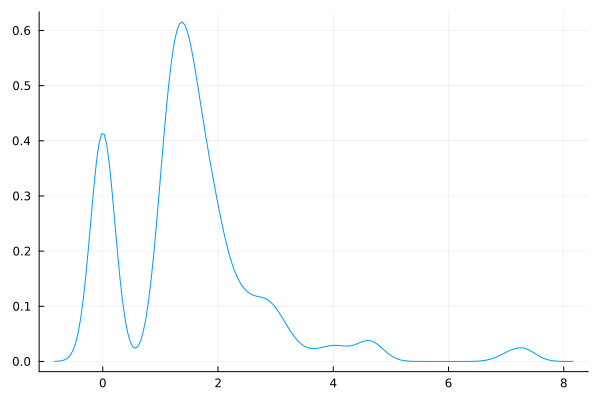

In [8]:
# Densidade
@df df density(:ROI, label=false)

In [9]:
# Instanciar os dados
X = Matrix(select(df, [:LL,:P1,:P2,:P3]))
y = df[:, :ROI]
model = robustreg(X, y);

In [10]:
# Cadeias de Markov
chain = sample(model, NUTS(), MCMCThreads(), 1_000, 4)
#summarystats(chain)
#show(summarystats(chain), allcols=true)
DataFrame(summarystats(chain))

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC C:\Users\User\.julia\packages\AbstractMCMC\fnRmh\src\sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.01168818473815918
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\User\.julia\packages\Turing\szPqN\src\inference\hmc.jl:191
Sampling (1 threads): 100%|█████████████████████████████| Time: 0:06:03


,parameters,mean,std,naive_se,mcse,ess,rhat,ess_per_sec
,Symbol,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,α,-0.695912,0.963196,0.0152295,0.121787,8.01603,6735.88,0.01532
2,β[1],1.15131,0.43762,0.00691938,0.0554312,8.01603,5909.59,0.01532
3,β[2],-0.170862,0.920783,0.0145589,0.11591,8.01603,15266.0,0.01532
4,β[3],-0.237161,0.189971,0.0030037,0.0239456,8.01603,9664.35,0.01532
5,β[4],-0.0518956,0.731039,0.0115587,0.0918779,8.01603,6170.25,0.01532
6,σ,1.186,1.2073,0.019089,0.15299,8.01603,4880.71,0.01532
7,ν,1.01981,0.933754,0.0147639,0.117802,8.01603,4573.63,0.01532


### Conclusão

Como pode ser observado nos resultados apresentados devemos aceitar a hipótese levantada pelo especialista de que investir em publicidade nas redes sociais tende a melhorar o desempenho da empresa. O coeficiente que representa o investimento em redes sociais ($\beta_1$) é positivo, ou seja, a cada um ponto percentual de aumento em redes sociais tende, em média, a aumentar a lucratividade (ROI) da empresa em R$1,15.

__Referências:__

* Wikipedia contributors. (2022, September 27). Robust statistics. In Wikipedia, The Free Encyclopedia. Retrieved 23:23, December 5, 2022, from https://en.wikipedia.org/w/index.php?title=Robust_statistics&oldid=1112685885

* Storopoli, J.E. (2022). Robust Bayesian Regression. In Bayesian Statistics using Julia and Turing, from https://storopoli.github.io/Bayesian-Julia/pages/10_robust_reg/